# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name: John Wilson**

---



In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
import math
import random
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [4]:
# Your code here.
class MDPLanding:
    def __init__(self, L):
        temp_states = []
        temp_terminal_states = {}
        for i in range(L+1):
            for j in range(L+1):
                for k in range(L+1):
                    temp_states.append((i, j, k))
                    if k == 0:
                        if j == L/2 and i == L/2:
                            temp_terminal_states[(i, j, k)] = 1
                        else:
                            temp_terminal_states[(i, j, k)] = -1 
        self.states = temp_states
        self.terminal_states = temp_terminal_states
        self.default_reward = -0.01
        self.all_actions = ["Up", "Down", "North", "South", "East", "West"]
        self.discount = 0.999
    
    def actions(self, state):
        possible_actions = self.all_actions.copy()
        (x, y, z) = state
        if (x+1, y, z) not in self.states:
            possible_actions.remove("East")
        if (x-1, y, z) not in self.states:
            possible_actions.remove("West")
        if (x, y+1, z) not in self.states:
            possible_actions.remove("North")
        if (x, y-1, z) not in self.states:
            possible_actions.remove("South")
        if (x, y, z+1) not in self.states:
            possible_actions.remove("Up")
        if (x, y, z-1) not in self.states:
            possible_actions.remove("Down")
        return possible_actions
    
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        possible_actions = self.actions(state)
        if action not in possible_actions:
            print("Invalid Move")
            return state
        (x, y, z) = state
        if action == "Up":
            state = (x, y, z+1)
        if action == "Down":
            state = (x, y, z-1)
        if action == "North":
            state = (x, y+1, z)
        if action == "South":
            state = (x, y-1, z)
        if action == "East":
            state = (x+1, y, z)
        if action == "West":
            state = (x-1, y, z)
        return state

In [5]:
test = MDPLanding(2)
print(test.states)
print(test.terminal_states)
print(test.actions((1, 0, 0)))
print(test.reward((1, 0, 0)))
print(test.result((1, 0, 0), "South"))

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
{(0, 0, 0): -1, (0, 1, 0): -1, (0, 2, 0): -1, (1, 0, 0): -1, (1, 1, 0): 1, (1, 2, 0): -1, (2, 0, 0): -1, (2, 1, 0): -1, (2, 2, 0): -1}
['Up', 'North', 'East', 'West']
-1
Invalid Move
(1, 0, 0)


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [6]:
# Your code here.
class Policy:
    def __init__(self, MDP):
        V_temp = {}
        policy_temp = {}
        for s in MDP.states:
            V_temp[s] = 0
            policy_temp[s] = random.choice(MDP.actions(s))
        self.V = V_temp
        self.policy = policy_temp
        self.MDP = MDP
        
    def policyEvaluation(self):
        for s in self.V:
            if s not in self.MDP.terminal_states:
                self.V[s] = self.MDP.reward(self.MDP.result(s, self.policy[s])) + self.MDP.discount * self.V[self.MDP.result(s, self.policy[s])]
                    
    def policyIteration(self, max_iterations):
        converged = False
        iterations = 0
        while not converged and iterations < max_iterations:
            converged = True
            iterations += 1
            self.policyEvaluation()
            for s in self.V:
                if s not in self.MDP.terminal_states:
                    temp = self.V[s]
                    for a in self.MDP.actions(s):
                        actionResult = self.MDP.reward(self.MDP.result(s, a)) + self.MDP.discount * self.V[self.MDP.result(s, a)]
                        if actionResult > temp:
                            converged = False
                            temp = actionResult
                            self.policy[s] = a

In [7]:
MDP_test = MDPLanding(4)
policy_test = Policy(MDP_test)
policy_test.policyIteration(6)
#THE POLICY FOR (2,2,1) SHOULD BE 'DOWN' AS IT IS RIGHT ABOVE THE LANDING PAD
print(policy_test.policy[(2,2,1)])
#THE POLICY FOR (0,2,1) SHOULD BE 'EAST' AS IT'S Y AND Z CORDINATES ARE ALREADY IN AN OPTIMAL POSITION AND HEADING 'EAST' OR IN THE POSITIVE X DIRECTION WILL BRING THE AGENT CLOSER TO LANDING PAD WITHOUT GETTING CLOSE OR LANDING ON A NON-OPTIMAL TERMINAL STATE
print(policy_test.policy[(0,2,1)])
#THE POLICY FOR (2,0,1) SHOULD BE 'NORTH' AS IT'S X AND Z CORDINATES ARE ALREADY IN AN OPTIMAL POSITION AND HEADING 'NORTH' OR IN THE POSITIVE Y DIRECTION WILL BRING THE AGENT CLOSER TO LANDING PAD WITHOUT GETTING CLOSE OR LANDING ON A NON-OPTIMAL TERMINAL STATE
print(policy_test.policy[(2,0,1)])

Down
East
North


#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [8]:
# Your code here.
def Q_Learner(MDP, episodes):
    Q = {}
    cumulativeRewardList = []
    alpha = .1
    epsilon = .1
    for s in MDP.states:
        Q[s] = {}
        for a in MDP.actions(s):
            Q[s][a] = 0
    for e in range(episodes):
        cur_s = random.choice(MDP.states)
        while cur_s in MDP.terminal_states:
            cur_s = random.choice(MDP.states)
        episodeCumulativeReward = 0
        while cur_s not in MDP.terminal_states:
            n = random.uniform(0, 1)
            cur_a = max(zip(Q[cur_s].values(), Q[cur_s].keys()))[1]
            if n < epsilon:
                val = list(Q[cur_s].values())
                val.sort()
                second_a = val[-2]
                key_list = list(Q[cur_s].keys())
                val_list = list(Q[cur_s].values())
                second_a = val_list.index(second_a)
                cur_a = key_list[second_a]
            new_s = MDP.result(cur_s, cur_a)
            reward = MDP.reward(new_s)
            episodeCumulativeReward += reward
            new_a = max(zip(Q[new_s].values(), Q[new_s].keys()))[1]
            Q[cur_s][cur_a] += alpha * (reward + MDP.discount * (Q[new_s][new_a] - Q[cur_s][cur_a])) 
            cur_s = new_s
        cumulativeRewardList.append(episodeCumulativeReward)
    return Q, cumulativeRewardList

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

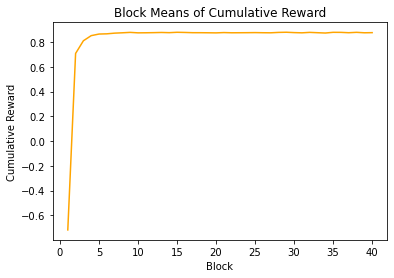

0.8137120000000002


In [13]:
# Your code here.
MDP_test_D = MDPLanding(10)
Q_test_D, cumulativeRewardList_test_D = Q_Learner(MDP_test_D, 20000)
blockMeans_test_D = [0] * 40
for i in range(len(blockMeans_test_D)):
    upper = (i+1) * 500
    lower = i * 500
    blockMeans_test_D[i] = np.mean(cumulativeRewardList_test_D[lower:upper])
x = list(range(1,len(blockMeans_test_D)+1))
y = blockMeans_test_D
plt.plot(x, y, color='orange')
plt.xlabel('Block')
plt.ylabel('Cumulative Reward')
plt.title('Block Means of Cumulative Reward')
plt.show()
print(np.mean(cumulativeRewardList_test_D[:-5000]))

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?
Due to the living reward of -0.01 for all non-terminal states, the fact that only the landing pad has a positive reward starting out, and the the drone's initial random placement the reward for almost every state is negative and it takes a few epsiodes before states start having postive reward.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?
Due to the living reward of -0.01 and the -1 reward for terminal states that are not the landing pad the reward for certain states is always going to be lower than others to account for the penalty of not landing on the landing pad so the cumulative reward is going to be limited to about 0.8 as the reward for states are determined by these variables

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

In [14]:
# Your code here.
class MDPLanding_TR1:
    def __init__(self, L):
        temp_states = []
        temp_terminal_states = {}
        for i in range(L+1):
            for j in range(L+1):
                for k in range(L+1):
                    temp_states.append((i, j, k))
                    if k == 0:
                        if j == L/2 and i == L/2:
                            temp_terminal_states[(i, j, k)] = 3
                        else:
                            temp_terminal_states[(i, j, k)] = -1 
        self.states = temp_states
        self.terminal_states = temp_terminal_states
        self.default_reward = -0.01
        self.all_actions = ["Up", "Down", "North", "South", "East", "West"]
        self.discount = 0.999
    
    def actions(self, state):
        possible_actions = self.all_actions.copy()
        (x, y, z) = state
        if (x+1, y, z) not in self.states:
            possible_actions.remove("East")
        if (x-1, y, z) not in self.states:
            possible_actions.remove("West")
        if (x, y+1, z) not in self.states:
            possible_actions.remove("North")
        if (x, y-1, z) not in self.states:
            possible_actions.remove("South")
        if (x, y, z+1) not in self.states:
            possible_actions.remove("Up")
        if (x, y, z-1) not in self.states:
            possible_actions.remove("Down")
        return possible_actions
    
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        possible_actions = self.actions(state)
        if action not in possible_actions:
            print("Invalid Move")
            return state
        (x, y, z) = state
        if action == "Up":
            state = (x, y, z+1)
        if action == "Down":
            state = (x, y, z-1)
        if action == "North":
            state = (x, y+1, z)
        if action == "South":
            state = (x, y-1, z)
        if action == "East":
            state = (x+1, y, z)
        if action == "West":
            state = (x-1, y, z)
        return state

class MDPLanding_TR2:
    def __init__(self, L):
        temp_states = []
        temp_terminal_states = {}
        for i in range(L+1):
            for j in range(L+1):
                for k in range(L+1):
                    temp_states.append((i, j, k))
                    if k == 0:
                        if j == L/2 and i == L/2:
                            temp_terminal_states[(i, j, k)] = 1
                        else:
                            temp_terminal_states[(i, j, k)] = -3 
        self.states = temp_states
        self.terminal_states = temp_terminal_states
        self.default_reward = -0.01
        self.all_actions = ["Up", "Down", "North", "South", "East", "West"]
        self.discount = 0.999
    
    def actions(self, state):
        possible_actions = self.all_actions.copy()
        (x, y, z) = state
        if (x+1, y, z) not in self.states:
            possible_actions.remove("East")
        if (x-1, y, z) not in self.states:
            possible_actions.remove("West")
        if (x, y+1, z) not in self.states:
            possible_actions.remove("North")
        if (x, y-1, z) not in self.states:
            possible_actions.remove("South")
        if (x, y, z+1) not in self.states:
            possible_actions.remove("Up")
        if (x, y, z-1) not in self.states:
            possible_actions.remove("Down")
        return possible_actions
    
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        possible_actions = self.actions(state)
        if action not in possible_actions:
            print("Invalid Move")
            return state
        (x, y, z) = state
        if action == "Up":
            state = (x, y, z+1)
        if action == "Down":
            state = (x, y, z-1)
        if action == "North":
            state = (x, y+1, z)
        if action == "South":
            state = (x, y-1, z)
        if action == "East":
            state = (x+1, y, z)
        if action == "West":
            state = (x-1, y, z)
        return state
    
class MDPLanding_LR:
    def __init__(self, L):
        temp_states = []
        temp_terminal_states = {}
        for i in range(L+1):
            for j in range(L+1):
                for k in range(L+1):
                    temp_states.append((i, j, k))
                    if k == 0:
                        if j == L/2 and i == L/2:
                            temp_terminal_states[(i, j, k)] = 1
                        else:
                            temp_terminal_states[(i, j, k)] = -1 
        self.states = temp_states
        self.terminal_states = temp_terminal_states
        self.default_reward = -0.05
        self.all_actions = ["Up", "Down", "North", "South", "East", "West"]
        self.discount = 0.999
    
    def actions(self, state):
        possible_actions = self.all_actions.copy()
        (x, y, z) = state
        if (x+1, y, z) not in self.states:
            possible_actions.remove("East")
        if (x-1, y, z) not in self.states:
            possible_actions.remove("West")
        if (x, y+1, z) not in self.states:
            possible_actions.remove("North")
        if (x, y-1, z) not in self.states:
            possible_actions.remove("South")
        if (x, y, z+1) not in self.states:
            possible_actions.remove("Up")
        if (x, y, z-1) not in self.states:
            possible_actions.remove("Down")
        return possible_actions
    
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        possible_actions = self.actions(state)
        if action not in possible_actions:
            print("Invalid Move")
            return state
        (x, y, z) = state
        if action == "Up":
            state = (x, y, z+1)
        if action == "Down":
            state = (x, y, z-1)
        if action == "North":
            state = (x, y+1, z)
        if action == "South":
            state = (x, y-1, z)
        if action == "East":
            state = (x+1, y, z)
        if action == "West":
            state = (x-1, y, z)
        return state

Down
East
North
Down
East
North
Down
East
North


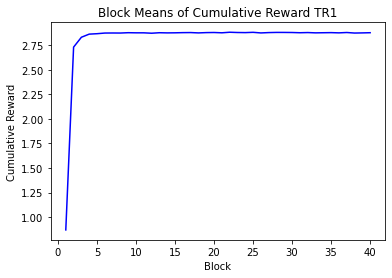

2.802150666666667


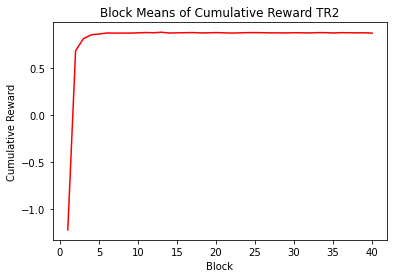

0.7980280000000004


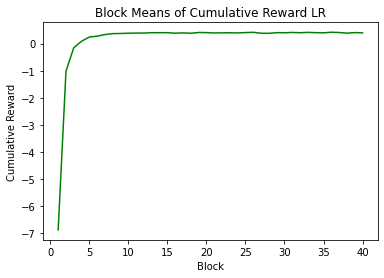

0.06388333333333335


In [15]:
MDP_TR1_test = MDPLanding_TR1(4)
policy_test_TR1 = Policy(MDP_TR1_test)
policy_test_TR1.policyIteration(6)
print(policy_test_TR1.policy[(2,2,1)])
print(policy_test_TR1.policy[(0,2,1)])
print(policy_test_TR1.policy[(2,0,1)])
MDP_TR2_test = MDPLanding_TR2(4)
policy_test_TR2 = Policy(MDP_TR2_test)
policy_test_TR2.policyIteration(6)
print(policy_test_TR2.policy[(2,2,1)])
print(policy_test_TR2.policy[(0,2,1)])
print(policy_test_TR2.policy[(2,0,1)])
MDP_LR_test = MDPLanding_LR(4)
policy_test_LR = Policy(MDP_LR_test)
policy_test_LR.policyIteration(6)
print(policy_test_LR.policy[(2,2,1)])
print(policy_test_LR.policy[(0,2,1)])
print(policy_test_LR.policy[(2,0,1)])
MDP_test_TR1 = MDPLanding_TR1(10)
Q_test_TR1, cumulativeRewardList_test_TR1 = Q_Learner(MDP_test_TR1, 20000)
blockMeans_test_TR1 = [0] * 40
for i in range(len(blockMeans_test_TR1)):
    upper = (i+1) * 500
    lower = i * 500
    blockMeans_test_TR1[i] = np.mean(cumulativeRewardList_test_TR1[lower:upper])
x_TR1 = list(range(1,len(blockMeans_test_TR1)+1))
y_TR1 = blockMeans_test_TR1
plt.plot(x_TR1, y_TR1, color='blue')
plt.xlabel('Block')
plt.ylabel('Cumulative Reward')
plt.title('Block Means of Cumulative Reward TR1')
plt.show()
print(np.mean(cumulativeRewardList_test_TR1[:-5000]))
MDP_test_TR2 = MDPLanding_TR2(10)
Q_test_TR2, cumulativeRewardList_test_TR2 = Q_Learner(MDP_test_TR2, 20000)
blockMeans_test_TR2 = [0] * 40
for i in range(len(blockMeans_test_TR2)):
    upper = (i+1) * 500
    lower = i * 500
    blockMeans_test_TR2[i] = np.mean(cumulativeRewardList_test_TR2[lower:upper])
x_TR2 = list(range(1,len(blockMeans_test_TR2)+1))
y_TR2 = blockMeans_test_TR2
plt.plot(x_TR2, y_TR2, color='red')
plt.xlabel('Block')
plt.ylabel('Cumulative Reward')
plt.title('Block Means of Cumulative Reward TR2')
plt.show()
print(np.mean(cumulativeRewardList_test_TR2[:-5000]))
MDP_test_LR = MDPLanding_LR(10)
Q_test_LR, cumulativeRewardList_test_LR = Q_Learner(MDP_test_LR, 20000)
blockMeans_test_LR = [0] * 40
for i in range(len(blockMeans_test_LR)):
    upper = (i+1) * 500
    lower = i * 500
    blockMeans_test_LR[i] = np.mean(cumulativeRewardList_test_LR[lower:upper])
x_LR = list(range(1,len(blockMeans_test_LR)+1))
y_LR = blockMeans_test_LR
plt.plot(x_LR, y_LR, color='green')
plt.xlabel('Block')
plt.ylabel('Cumulative Reward')
plt.title('Block Means of Cumulative Reward LR')
plt.show()
print(np.mean(cumulativeRewardList_test_LR[:-5000]))

#### Terminal Rewards 1 Expected: 
For this reward structure I changed the Terminal Reward for the Landing Pad from 1 to 3 and since I am increasing the reward for just 1 terminal state I expect the algorithm to heavily lean towards find a path to this spot in other word it will have a strong bias towards this spot as it's reward is well above all other termial states and the algorithm might avoid find better paths than if it wasn't heavily biased towar the landing pad.
#### Terminal Rewards 1 Actually Happened: 
The results for Policy Iteration were the same as the original reward structure. The cumulative reward for Q-Learning was much higher at about 2.80.

#### Difference Explaination:
The difference here is not what I expected but it seems that due to the high reward for the landing pad the cumulative reward was much higher as well even though the graph of the cumulative reward is follows the same pattern as the orginal. This is probably because the expected reward function produceds higher valued outputs due to the higher landing pad reward.

#### Terminal Rewards 2 Expected:
For this reward structure I changed the Terminal Reward for all terminal states except the Landing Pad from -1 to -3 and since I am increasing the punishment for all Terminal States except the landing pad I expected as more and more episodes are run that the algorithm will learn to heavily avoid landing on Terminal States that are not that Landing Pad and so it may take longer to find a solution as the drone will be more hesitant to take risks and learn from failures.
#### Terminal Rewards 2 Actually Happened:
The results for Policy Iteration were the same as the original reward structure. The cumulative reward for Q-Learning was about the same at 0.79. 

#### Difference Explaination:
The difference here is not what I expected but it seems that higher punishment for the terminal states other than the landing pad slightly lower the cumulative reward for Q-learning from the orignal but it hardly changes at all really and the graph of the cumulative reward is follows the same pattern as the orginal. This is probably because the terminal states other than the landing pad in the original implementation were already negtive and were avoided and increasing the amount of punishment doesn't change the behavior all that much.

#### Living Rewards Expected:
For this reward structure I changed teh Living Reward from -0.01 to -0.05 and since I am increasing the living reward the drone is going to want to find a solution faster as living is more expensive this may lead the robot to be more willing to choose to go to a terminal state that is not the landing pad if finding the landing pad is taking a long time. This may result in takingm more episodes to find a solution as if the drone is place to far from the landing pad too often (from the random state generator) the drone may kill itself a lot before it finds a solution.

#### Living Rewards Actually Happened:
The results for Policy Iteration were the same as the original reward structure. The cumulative reward for Q-Learning was much lower at about 0.06.

#### Difference Explaination:
The difference here is not what I expected but it seems that increasing the living rewards significantly decrease the cumulative reward for Q-learning when compared to the original implementation and the graph of the cumulative reward is follows the same pattern as the orginal. This probably because trying to solve the puzzle of getting to the landing pad is more costly not matter how fast the drone solves the puzzle because the reward for every non-terminal state is way more negative so the final cumulative rewards is going to be way more negative.